In [15]:
import pandas as pd
import numpy as np
import talib
from talib.abstract import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti

mpl.style.use('ggplot')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, recall_score, \
                            roc_curve, auc, roc_auc_score, precision_recall_curve

from imblearn.over_sampling import SMOTE

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from collections import Counter, OrderedDict, defaultdict
import operator
from pprint import pprint as pp

%matplotlib inline
np.random.seed(42)
pd.options.display.max_columns = None

In [16]:
# !python ../scripts/binance_api_data_collector.py --symbol BTCUSDT --interval 15m --frm 1/1/2017 --to 6/6/2018
# print('Done')
# !python ../scripts/binance_api_data_collector.py --symbol ETHUSDT --interval 15m --frm 1/1/2017 --to 6/6/2018
# print('Done')
# !python ../scripts/binance_api_data_collector.py --symbol LTCUSDT --interval 15m --frm 1/1/2017 --to 6/6/2018
# print('Done')
# !python ../scripts/binance_api_data_collector.py --symbol XRPBTC --interval 15m --frm 1/1/2017 --to 6/6/2018
# print('Done')

In [17]:
crypto = 'LTCUSDT'
filepath = '../data/%s-2017-01-01 -2018-06-06 .csv'%crypto
ticker = filepath.split('/')[-1].split('-')[0]
df = pd.read_csv(filepath)
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1513135800000,272.0,288.0,272.00,288.0,46.61841,1513136699999,12811.749890,20,2.41562,678.252680,265907.985446
1,1513136700000,280.0,281.0,275.50,276.0,84.24234,1513137599999,23419.585795,45,9.46000,2640.920250,265049.598083
2,1513137600000,276.0,284.1,274.90,275.0,111.29432,1513138499999,31049.905412,44,14.73788,4119.886055,265677.282718
3,1513138500000,275.0,275.0,269.99,270.0,239.56996,1513139399999,65110.881981,33,29.72594,8045.349914,264975.004646
4,1513139400000,270.0,284.1,270.00,274.0,151.75646,1513140299999,41506.667562,41,54.90927,15082.590631,263848.244072


In [18]:
df.isnull().sum()

Open time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
Ignore                          0
dtype: int64

In [19]:
df.describe()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
count,1.661600e+04,16616.000000,16616.000000,16616.000000,16616.000000,16616.000000,1.661600e+04,1.661600e+04,16616.000000,16616.000000,1.661600e+04,16616.000000
mean,1.520704e+12,178.110201,179.328069,176.899066,178.095561,1284.961880,1.520705e+12,2.256427e+05,465.157078,619.776814,1.083136e+05,8108.842500
std,4.365703e+09,52.174006,52.915513,51.496103,52.165957,1747.621580,4.365703e+09,3.487976e+05,1076.094781,895.059611,1.768006e+05,45262.249671
min,1.513136e+12,107.660000,110.010000,106.500000,107.330000,0.513990,1.513137e+12,1.604805e+02,3.000000,0.000000,0.000000e+00,0.000000
25%,1.516884e+12,137.000000,137.617500,136.415000,137.017500,350.878740,1.516885e+12,6.095290e+04,164.000000,146.933398,2.548082e+04,0.000000
50%,1.520746e+12,162.900000,163.810000,162.000000,162.885000,720.919265,1.520747e+12,1.198375e+05,278.000000,324.264750,5.517340e+04,0.000000
75%,1.524484e+12,213.242500,214.500000,212.150000,213.240000,1498.337053,1.524485e+12,2.467000e+05,521.000000,735.136757,1.179520e+05,0.000000
max,1.528222e+12,365.980000,366.960000,365.000000,365.990000,28628.828990,1.528223e+12,6.394789e+06,117192.000000,15268.481720,3.527603e+06,275896.274196


In [20]:
df.drop(['Close time', 'Ignore'], axis=1, inplace=True)
df.head()

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1513135800000,272.0,288.0,272.00,288.0,46.61841,12811.749890,20,2.41562,678.252680
1,1513136700000,280.0,281.0,275.50,276.0,84.24234,23419.585795,45,9.46000,2640.920250
2,1513137600000,276.0,284.1,274.90,275.0,111.29432,31049.905412,44,14.73788,4119.886055
3,1513138500000,275.0,275.0,269.99,270.0,239.56996,65110.881981,33,29.72594,8045.349914
4,1513139400000,270.0,284.1,270.00,274.0,151.75646,41506.667562,41,54.90927,15082.590631


<Figure size 2880x720 with 0 Axes>

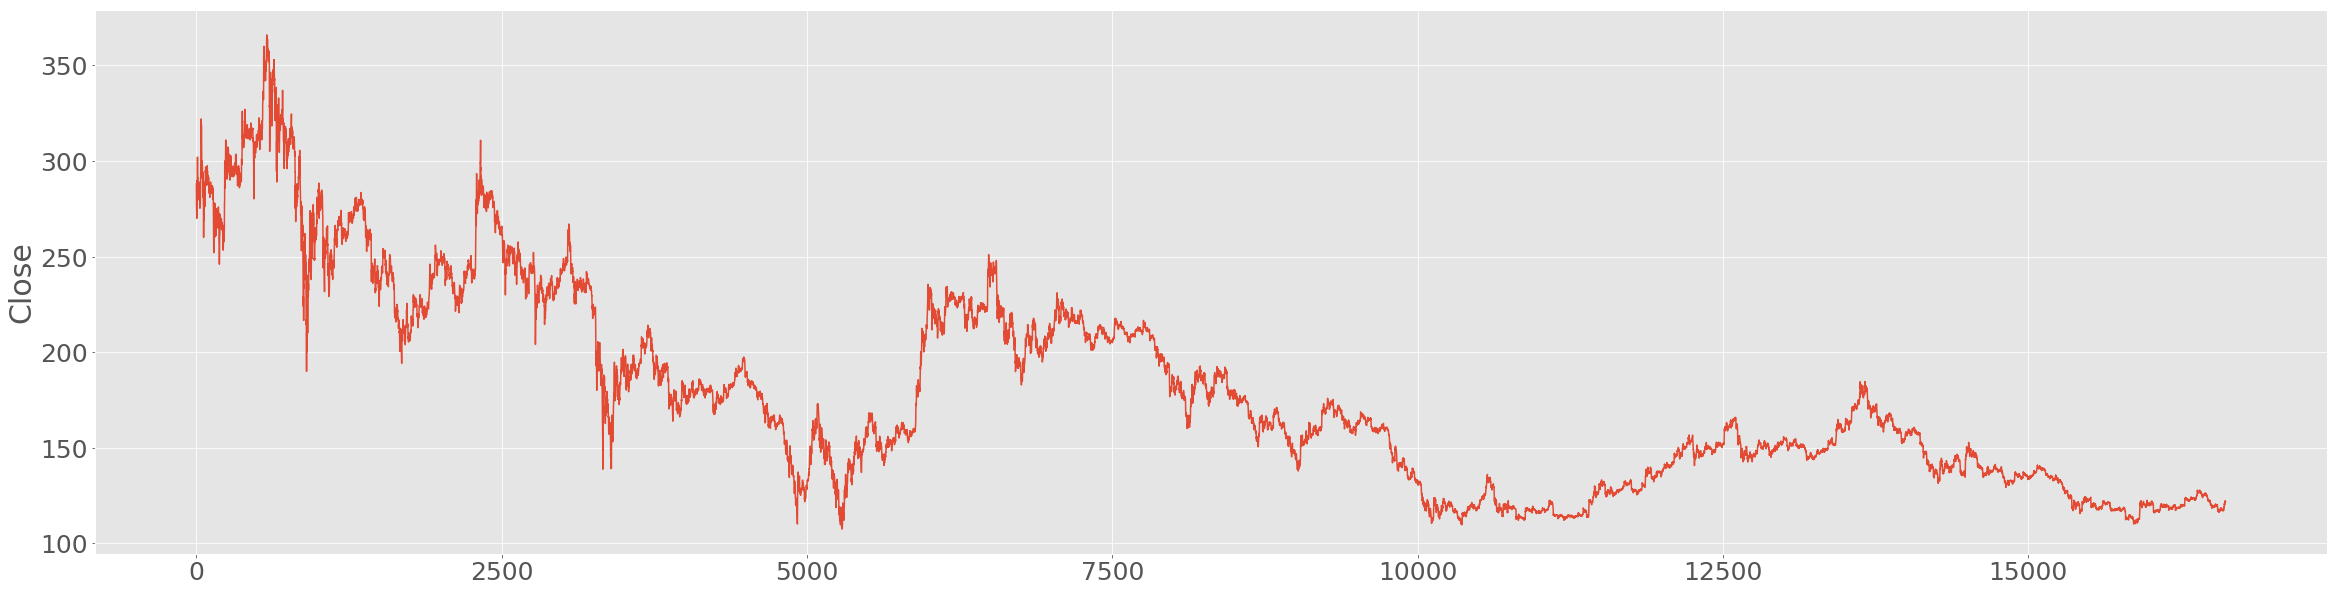

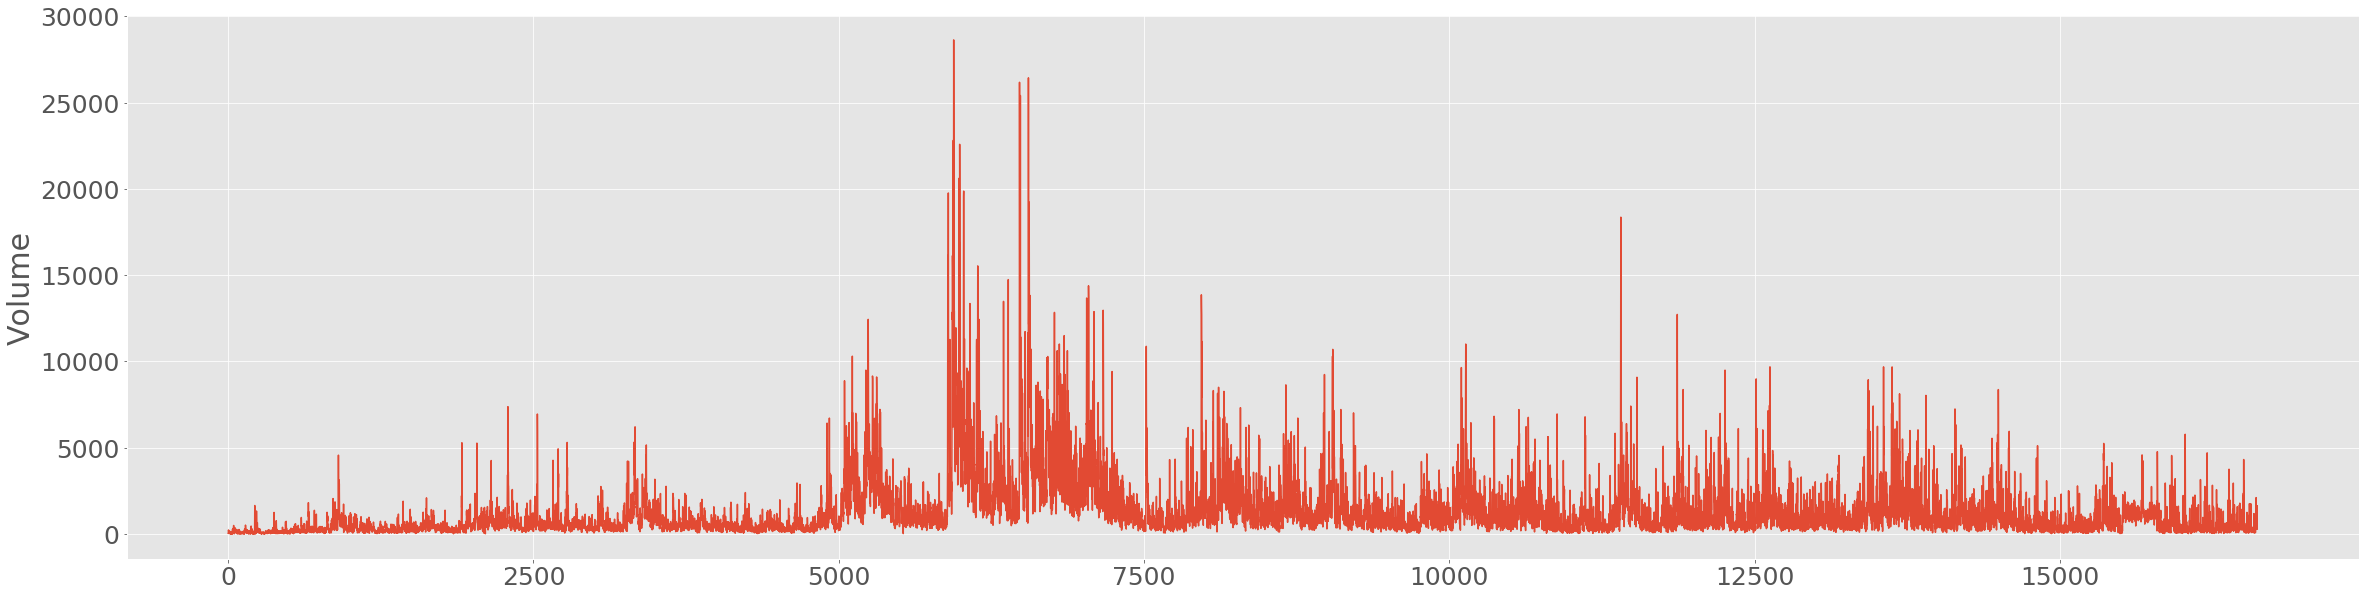

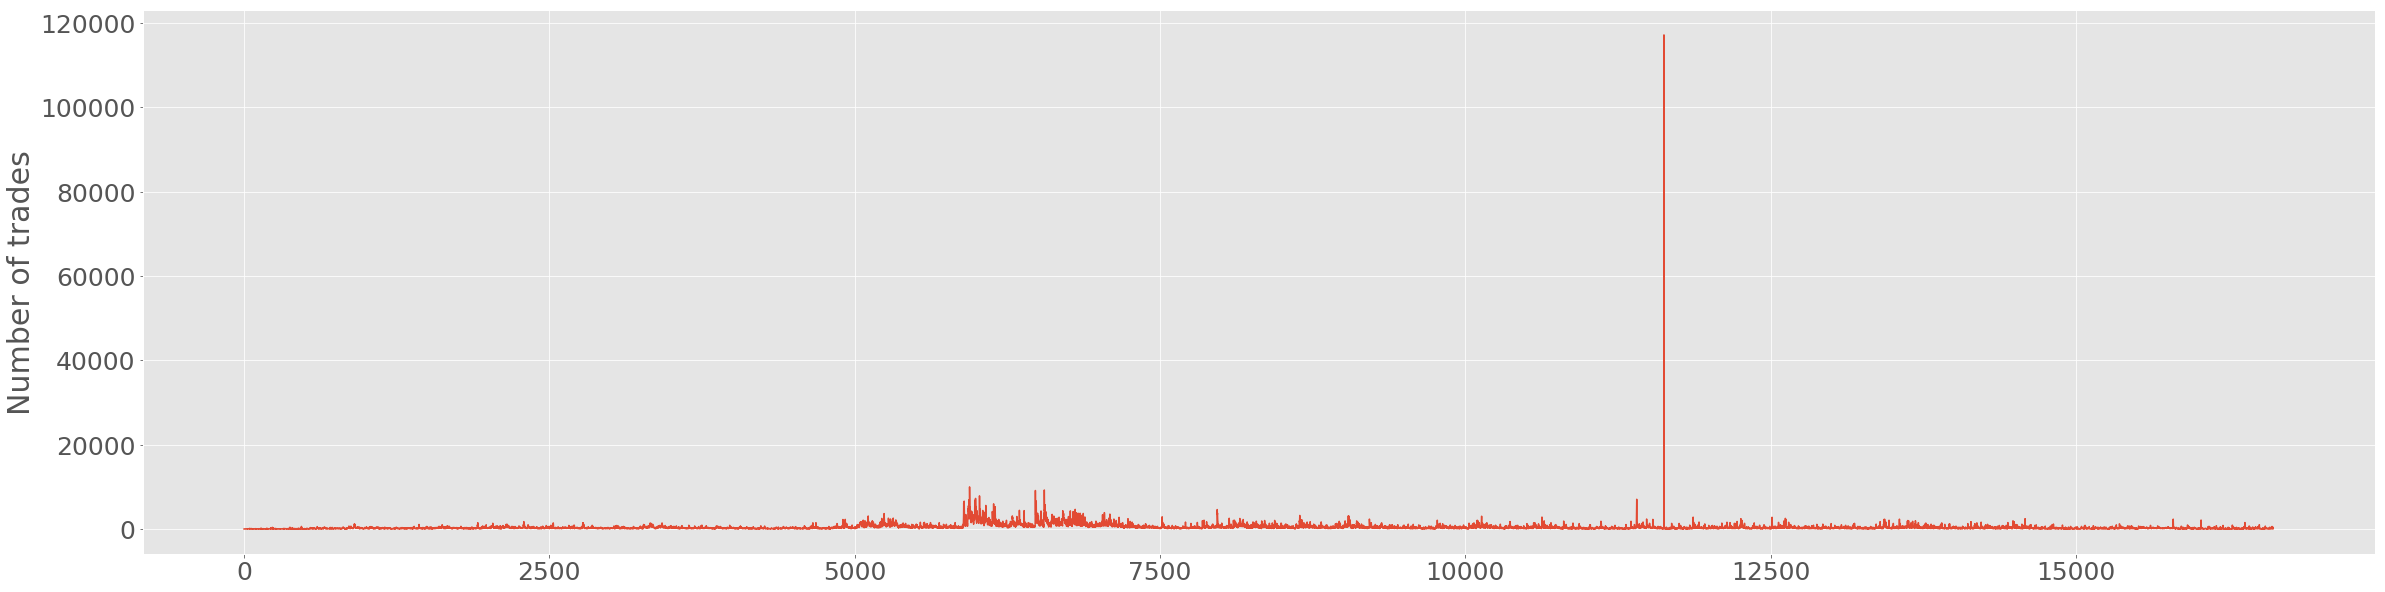

In [21]:
plt.figure(figsize=(40,10))
mpl.rcParams.update({'font.size': 25})
for f in ['Close', 'Volume', 'Number of trades']:
    plt.figure(figsize=(40,10))
    mpl.rcParams.update({'font.size': 25})
    plt.plot(getattr(df, f))
    plt.ylabel(f)
    plt.show()

In [22]:
analysis = talib.get_function_groups()
analysis

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

In [24]:
# df['SMA'] = SMA(inputs, timeperiod=25)

In [25]:
inputs = {
    'open': df.Open,
    'high': df.High,
    'low': df.Low,
    'close': df.Close,
    'volume': df.Volume
}

for f in analysis['Pattern Recognition'] + analysis['Volume Indicators'] + analysis['Volatility Indicators'] + analysis['Statistic Functions']:
#        + analysis['Momentum Indicators']:
            
    output = getattr(talib.abstract, f)(inputs)
    if isinstance(output, np.ndarray):
        print(f)
        df[f] = output
    else:
        for i in range(len(output)):
            f_i = '%s_%s'%(f, i)
            print(f_i)
            df[f_i] = output[i]
            
df['SMA'] = SMA(inputs, timeperiod=25)
df['RSI'] = RSI(inputs, timeperiod=25)

CDL2CROWS
CDL3BLACKCROWS
CDL3INSIDE
CDL3LINESTRIKE
CDL3OUTSIDE
CDL3STARSINSOUTH
CDL3WHITESOLDIERS
CDLABANDONEDBABY
CDLADVANCEBLOCK
CDLBELTHOLD
CDLBREAKAWAY
CDLCLOSINGMARUBOZU
CDLCONCEALBABYSWALL
CDLCOUNTERATTACK
CDLDARKCLOUDCOVER
CDLDOJI
CDLDOJISTAR
CDLDRAGONFLYDOJI
CDLENGULFING
CDLEVENINGDOJISTAR
CDLEVENINGSTAR
CDLGAPSIDESIDEWHITE
CDLGRAVESTONEDOJI
CDLHAMMER
CDLHANGINGMAN
CDLHARAMI
CDLHARAMICROSS
CDLHIGHWAVE
CDLHIKKAKE
CDLHIKKAKEMOD
CDLHOMINGPIGEON
CDLIDENTICAL3CROWS
CDLINNECK
CDLINVERTEDHAMMER
CDLKICKING
CDLKICKINGBYLENGTH
CDLLADDERBOTTOM
CDLLONGLEGGEDDOJI
CDLLONGLINE
CDLMARUBOZU
CDLMATCHINGLOW
CDLMATHOLD
CDLMORNINGDOJISTAR
CDLMORNINGSTAR
CDLONNECK
CDLPIERCING
CDLRICKSHAWMAN
CDLRISEFALL3METHODS
CDLSEPARATINGLINES
CDLSHOOTINGSTAR
CDLSHORTLINE
CDLSPINNINGTOP
CDLSTALLEDPATTERN
CDLSTICKSANDWICH
CDLTAKURI
CDLTASUKIGAP
CDLTHRUSTING
CDLTRISTAR
CDLUNIQUE3RIVER
CDLUPSIDEGAP2CROWS
CDLXSIDEGAP3METHODS
AD
ADOSC
OBV
ATR
NATR
TRANGE
BETA
CORREL
LINEARREG
LINEARREG_ANGLE
LINEARREG_INTERCEPT
LINEARR

In [26]:
df.head()

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,AD,ADOSC,OBV,ATR,NATR,TRANGE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,SMA,RSI
0,1513135800000,272.0,288.0,272.00,288.0,46.61841,12811.749890,20,2.41562,678.252680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46.618410,NaN,46.61841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1513136700000,280.0,281.0,275.50,276.0,84.24234,23419.585795,45,9.46000,2640.920250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-22.307141,NaN,-37.62393,NaN,NaN,12.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1513137600000,276.0,284.1,274.90,275.0,111.29432,31049.905412,44,14.73788,4119.886055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-131.182019,NaN,-148.91825,NaN,NaN,9.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1513138500000,275.0,275.0,269.99,270.0,239.56996,65110.881981,33,29.72594,8045.349914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-369.795612,NaN,-388.48821,NaN,NaN,5.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1513139400000,270.0,284.1,270.00,274.0,151.75646,41506.667562,41,54.90927,15082.590631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-435.449116,NaN,-236.73175,NaN,NaN,14.10,NaN,NaN,NaN,NaN,NaN,NaN,6.053098,NaN,36.64,NaN,NaN


In [27]:
print(len(df))
print(len(df.columns))

16616
88


In [28]:
df['Returns_1hr'] = df.Close.shift(4)/df.Close*100 -100
df['Returns_1hr'].describe()

count    16612.000000
mean         0.036902
std          1.848841
min        -25.223768
25%         -0.688812
50%          0.013725
75%          0.742441
max         21.308047
Name: Returns_1hr, dtype: float64

In [29]:
df['Returns_2hr'] = df.Close.shift(8)/df.Close*100 -100
df['Returns_2hr'].describe()

count    16608.000000
mean         0.071900
std          2.522737
min        -25.280172
25%         -0.981961
50%          0.013834
75%          1.057275
max         36.277762
Name: Returns_2hr, dtype: float64

In [30]:
df['Returns_3hr'] = df.Close.shift(12)/df.Close*100 -100
df['Returns_3hr'].describe()

count    16604.000000
mean         0.104699
std          2.935269
min        -23.266752
25%         -1.160966
50%          0.030308
75%          1.307062
max         37.006057
Name: Returns_3hr, dtype: float64

In [31]:
# plt.boxplot(df.Returns_1hr)

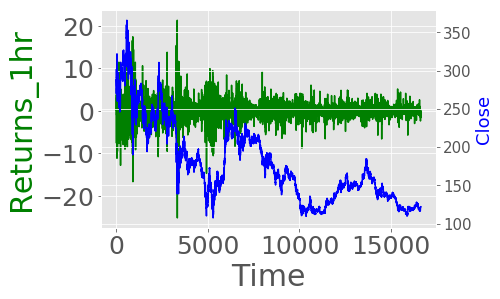

<Figure size 3600x720 with 0 Axes>

In [32]:
fig, ax1 = plt.subplots()
plt.figure(figsize=(50,10))

mpl.rcParams.update({'font.size': 15})
ax2 = ax1.twinx()

x = range(len(df))
ax1.plot(x, df.Returns_1hr, 'g-')
ax2.plot(x, df.Close, 'b-')

ax1.set_xlabel('Time')
ax1.set_ylabel('Returns_1hr', color='g')
ax2.set_ylabel('Close', color='b')
# plt.tight_layout()
plt.show()

In [33]:
# Removing starting rows containing NA due to time series
# df = df.iloc[50:]

In [34]:
temp = df.Returns_3hr.apply(np.floor).dropna()
Counter(temp)

Counter({-24.0: 1,
         -20.0: 1,
         -19.0: 3,
         -18.0: 3,
         -17.0: 1,
         -16.0: 4,
         -15.0: 8,
         -14.0: 8,
         -13.0: 9,
         -12.0: 22,
         -11.0: 27,
         -10.0: 39,
         -9.0: 47,
         -8.0: 91,
         -7.0: 125,
         -6.0: 204,
         -5.0: 358,
         -4.0: 612,
         -3.0: 979,
         -2.0: 2030,
         -1.0: 3595,
         0.0: 3547,
         1.0: 1981,
         2.0: 1088,
         3.0: 749,
         4.0: 367,
         5.0: 267,
         6.0: 142,
         7.0: 79,
         8.0: 68,
         9.0: 37,
         10.0: 29,
         11.0: 14,
         12.0: 19,
         13.0: 11,
         14.0: 7,
         15.0: 6,
         16.0: 5,
         17.0: 3,
         18.0: 5,
         19.0: 1,
         20.0: 3,
         21.0: 3,
         22.0: 1,
         23.0: 2,
         25.0: 1,
         34.0: 1,
         37.0: 1})

In [35]:
def assign_class(x):
    if x>=5:
        return 5
    elif x<=-5:
        return -5
    else:
        return np.trunc(x)
    
assign_class(-0.1)

-0.0

In [36]:
df['Returns_3hr'] = df.Returns_3hr.apply(assign_class)

In [37]:
# Dropping unnecessary variables
df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 
         'Quote asset volume', 'Number of trades', 
         'Taker buy base asset volume', 'Taker buy quote asset volume'], 
          axis=1, inplace=True)

# Dropping created variables
df.drop(['Returns_1hr', 'Returns_2hr'], axis=1, inplace=True)

In [38]:
df.dropna(inplace=True)
df.to_csv('../data/%s_train_data.csv'%ticker, index=False)
print('saved')

saved


In [39]:
# import glob

# frame = pd.DataFrame()
# list_ = []
# for file_ in glob.glob("../data/*_train_data.csv"):
#     print(file_)
#     df = pd.read_csv(file_,index_col=None, header=0)
#     list_.append(df)
# frame = pd.concat(list_)
# frame.to_csv('../data/training_data.csv', index=False)
# print('saved')

../data\BTCUSDT_train_data.csv
../data\ETHUSDT_train_data.csv
../data\LTCUSDT_train_data.csv
../data\XRPBTC_train_data.csv
saved


In [45]:
# import os

# import numpy as np
# import pandas as pd
# from talib import abstract
# # from talib.abstract import *

# import binance_api_data_collector as binance

# os.getcwd()

# features = ['LINEARREG_SLOPE', 'NATR', 'LINEARREG_ANGLE', 'RSI', 'ADOSC', 'OBV',
#             'AD', 'LINEARREG_INTERCEPT', 'BETA', 'VAR',
#             'STDDEV', 'ATR', 'CORREL', 'TRANGE', 'CDLBELTHOLD', 'CDLLONGLINE',
#             'CDLCLOSINGMARUBOZU', 'CDLSHORTLINE', 'CDLHIKKAKE']

# def get_last_data(api='binance', symbol='BTCUSDT', interval='15m', limit=30):
#     if api == 'binance':
#         data = binance.klines(symbol, interval=interval, limit=limit)

#     columns = ["open time", "open", "high", "low", "close", "volume", "close time"]
#     return pd.DataFrame(np.array(data[3])[:, :7], columns=columns, dtype='float64')


# def get_features_df(df):
#     inputs = {
#         'open': df.open,
#         'high': df.high,
#         'low': df.low,
#         'close': df.close,
#         'volume': df.volume
#     }
#     for f in features:
#         output = getattr(abstract, f)(inputs)
#         if isinstance(output, np.ndarray):
#             df[f] = output
#         else:
#             for i in range(len(output)):
#                 f_i = '%s_%s' % (f, i)
#                 df[f_i] = output[i]

#     df.drop(["open", "high", "low", "close", "volume"], axis=1, inplace=True)
#     return df.dropna()


# get_features_df(get_last_data()).head()


200


,open time,close time,LINEARREG_SLOPE,NATR,LINEARREG_ANGLE,RSI,ADOSC,OBV,AD,LINEARREG_INTERCEPT,BETA,VAR,STDDEV,ATR,CORREL,TRANGE,CDLBELTHOLD,CDLLONGLINE,CDLCLOSINGMARUBOZU,CDLSHORTLINE,CDLHIKKAKE
29,1.529083e+12,1.529084e+12,3.888,0.535328,75.576067,45.129662,-157.27347,244.292808,-569.666509,6509.293714,-0.069963,238.720304,15.450576,34.994408,0.639872,8.39,0,0,0,-100,0
